Analyze parameter dependencies informed by param sweep results from 3A.

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln, plot


DTCN_WDW = .1
TRJ_CUTOFF = .75
NTRJ_CUTOFF = .5

# Plot saved results

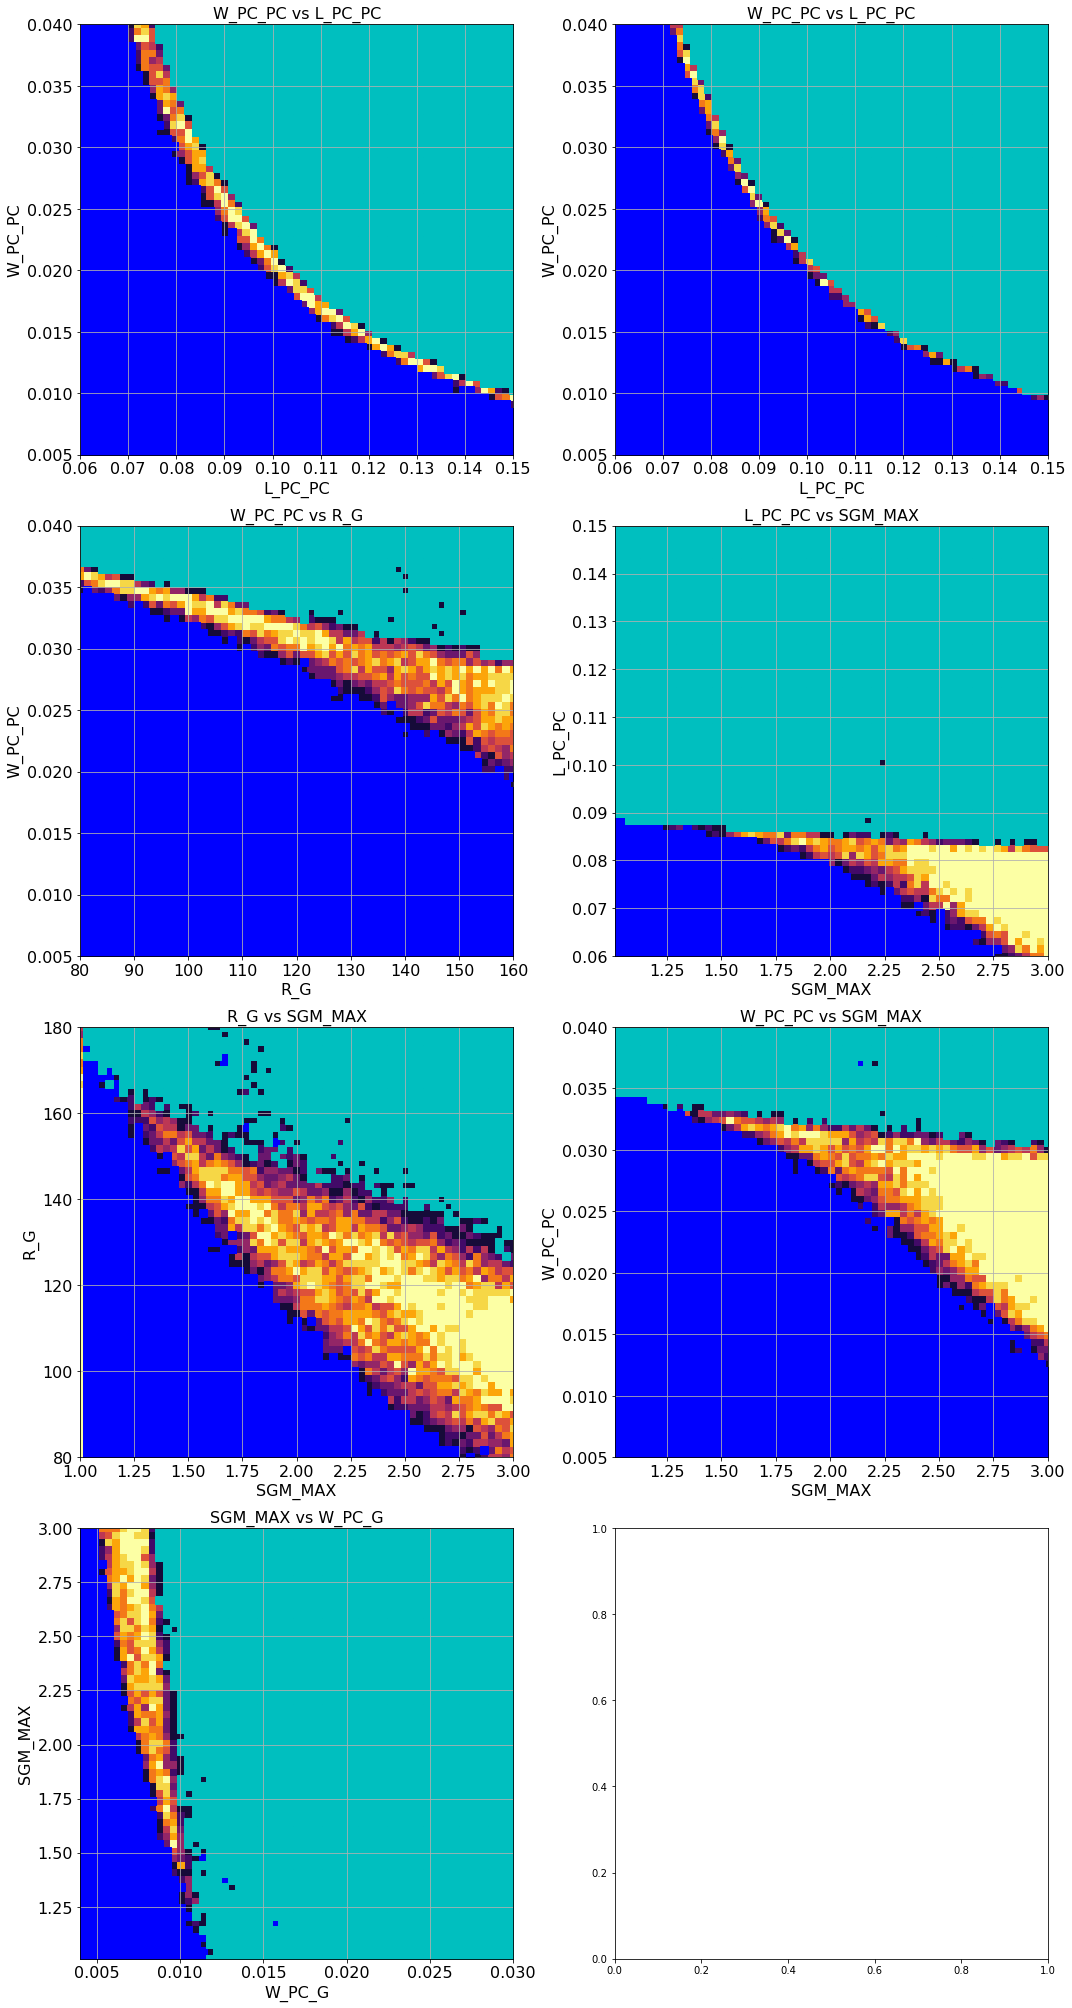

In [2]:
from ast import literal_eval

RSLT_FILES = [
    'replay_param_sweep_L_PC_PC_W_PC_PC_0.csv',
    'replay_param_sweep_L_PC_PC_W_PC_PC_1.csv',
    'replay_param_sweep_R_G_W_PC_PC_0.csv',
    'replay_param_sweep_SGM_MAX_L_PC_PC_0.csv',
    'replay_param_sweep_SGM_MAX_R_G_0.csv',
    'replay_param_sweep_SGM_MAX_W_PC_PC_0.csv',
    'replay_param_sweep_W_PC_G_SGM_MAX_0.csv',
]

m_paramss = []
s_paramss = []
cols = []
dfs = []

fig, axs = plt.subplots(4, 2, figsize=(15, 28), tight_layout=True)

for rslt_file, ax in zip(RSLT_FILES, axs.flatten()):
    
    with open(rslt_file, 'r') as f:
        m_params = literal_eval(f.readline().strip())
        s_params = literal_eval(f.readline().strip())

    df = pd.read_csv(rslt_file, header=2, index_col=0)

    col_x = df.columns[1]
    col_y = df.columns[2]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    n_replay = df['N_REPLAY']
    
    ax.scatter(vals_x, vals_y, marker='s', s=55, c=n_replay, cmap='inferno', vmin=0, vmax=10, lw=0, zorder=0)
    
    # color non-replay units by fadeout vs blowup
    df_fadeout = df[(n_replay == 0) & (df['N_FADEOUT'] > df['N_BLOWUP'])]
    ax.scatter(df_fadeout[col_x], df_fadeout[col_y], marker='s', s=55, c='b', zorder=1)
    
    df_blowup = df[(n_replay == 0) & (df['N_FADEOUT'] <= df['N_BLOWUP'])]
    ax.scatter(df_blowup[col_x], df_blowup[col_y], marker='s', s=55, c='c', zorder=1)
    
    
    ax.set_xlim(vals_x.min(), vals_x.max())
    ax.set_ylim(vals_y.min(), vals_y.max())
    
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.set_title('{} vs {}'.format(col_y, col_x))
    
    ax.grid()
    
    set_font_size(ax, 16)
    
    m_paramss.append(m_params)
    s_paramss.append(s_params)
    
    cols.append((col_x, col_y))
    
    dfs.append(df)

# Define fadeout, blowup, and replay, detection functions

In [3]:
def detect_rsp_type(rslt, m_params, s_params):
    # get mask over trj and non-trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & mask_pc
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    
    # get spk cts in for trj/non-trj cells during detection wdw
    spks_trj = rslt.spks[t_mask][:, trj_mask]
    spks_ntrj = rslt.spks[t_mask][:, ntrj_mask]
    
    # get frac of trj/non-trj cells that spikes
    p_spk_trj = np.mean(spks_trj.sum(0) > 0)
    p_spk_ntrj = np.mean(spks_ntrj.sum(0) > 0)
    
    # categorize event
    if p_spk_trj < TRJ_CUTOFF:
        return 'fadeout'
    elif p_spk_ntrj >= NTRJ_CUTOFF:
        return 'blowup'
    else:
        return 'replay'

# Example smlns

## Known functioning smlns

Running smln...
Smln complete.
replay


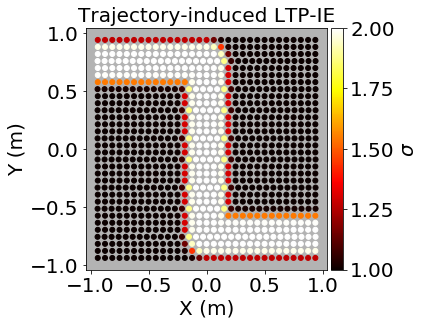

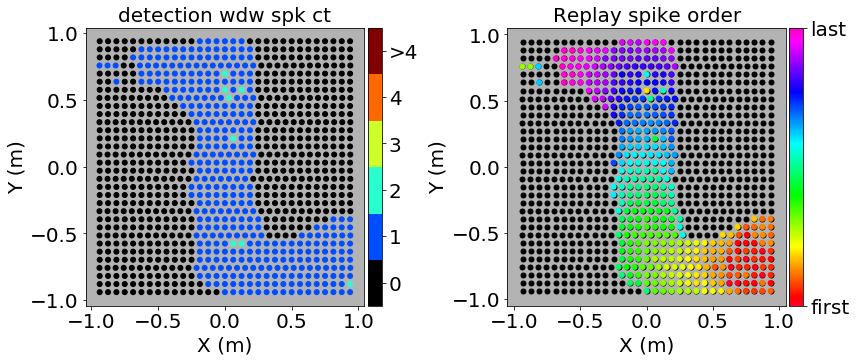

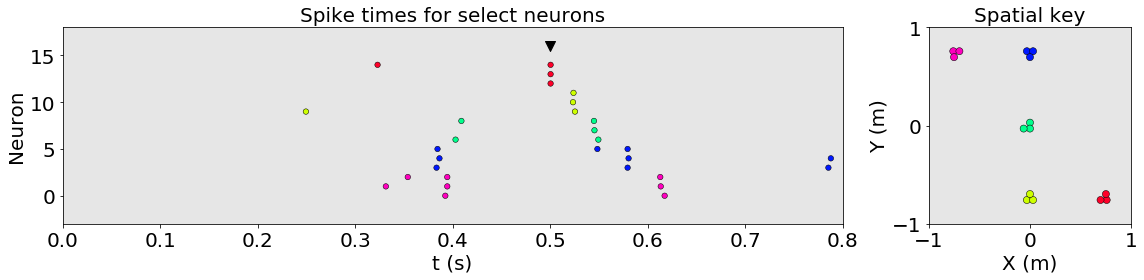

In [4]:
df = dfs[0]

m_params = copy(m_paramss[0])
s_params = copy(s_paramss[0])
s_params['RNG_SEED'] = 0

m_params['L_PC_PC'] = 0.088
m_params['W_PC_PC'] = 0.026

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow')

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons')

print(detect_rsp_type(rslt, m_params, s_params))

## Smln w/ large $\sigma_{max}$

Running smln...
Smln complete.
replay


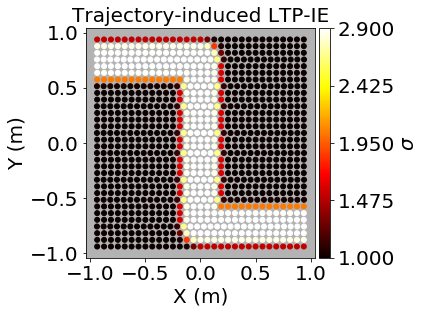

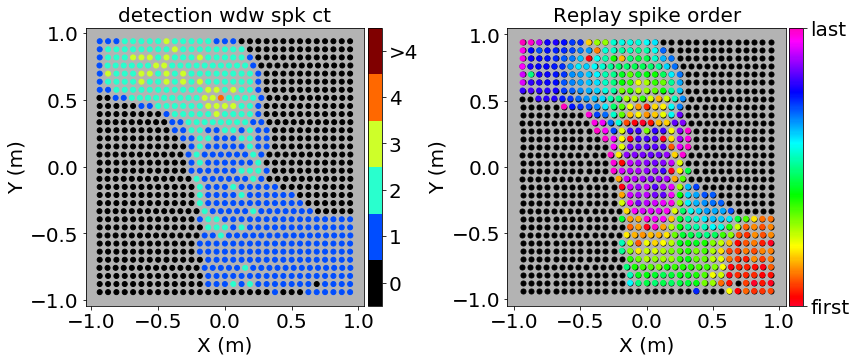

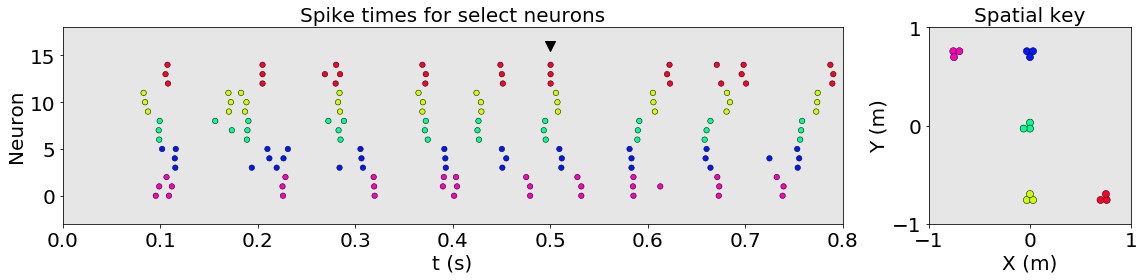

In [5]:
df = dfs[1]

m_params = copy(m_paramss[1])
s_params = copy(s_paramss[1])
s_params['RNG_SEED'] = 0

m_params['R_G'] = 100
m_params['SGM_MAX'] = 2.9

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow')

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons')

print(detect_rsp_type(rslt, m_params, s_params))

## Smln w/ smaller $\sigma_{max}$

Running smln...
Smln complete.
replay


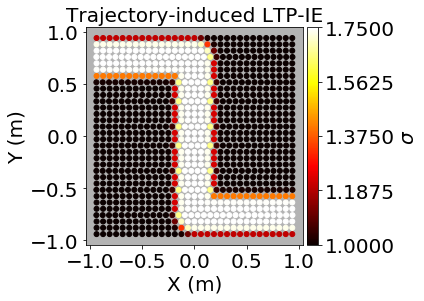

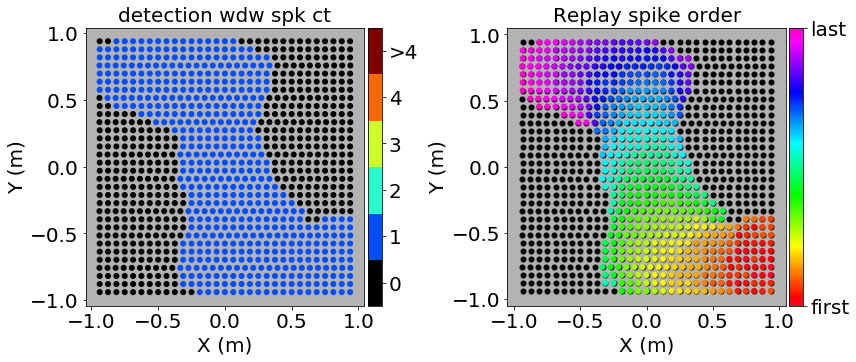

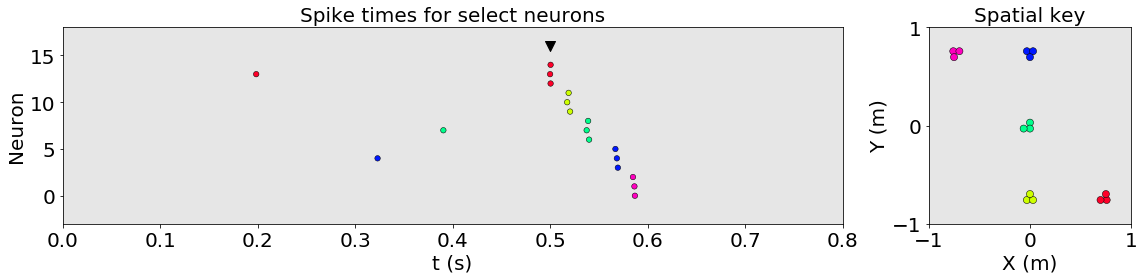

In [6]:
df = dfs[1]

m_params = copy(m_paramss[1])
s_params = copy(s_paramss[1])
s_params['RNG_SEED'] = 0

m_params['R_G'] = 140
m_params['SGM_MAX'] = 1.75

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow')

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons')

print(detect_rsp_type(rslt, m_params, s_params))

## Smln w/ medium $\sigma_{max}$

Running smln...
Smln complete.
replay


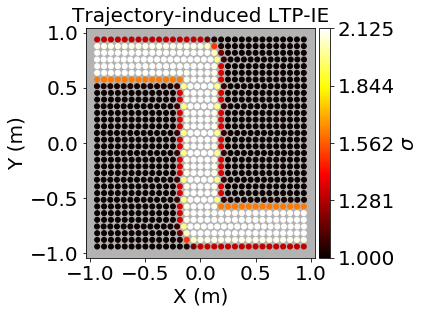

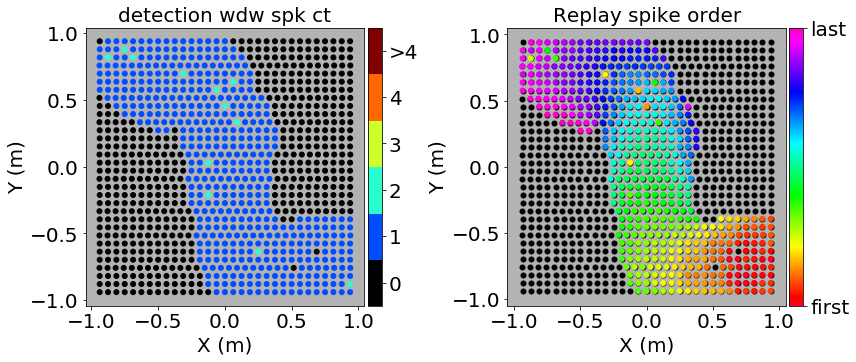

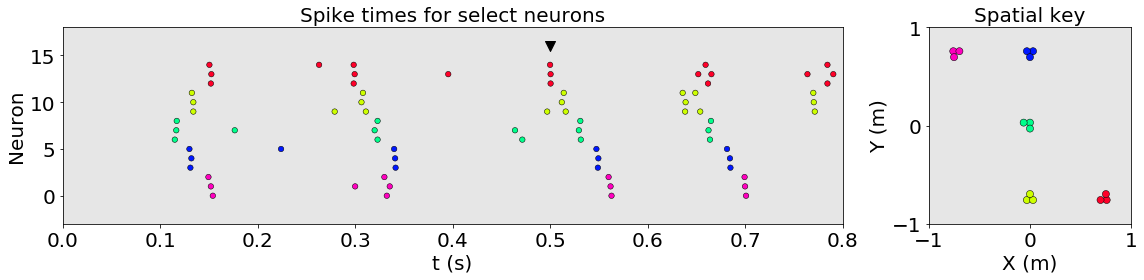

In [7]:
df = dfs[1]

m_params = copy(m_paramss[1])
s_params = copy(s_paramss[1])
s_params['RNG_SEED'] = 9

m_params['R_G'] = 128
m_params['SGM_MAX'] = 2.125

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

# make plots
plot.heat_maps(rslt, cmap='gist_rainbow')

plot.raster(
    rslt,
    xys=[
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    ],
    colors=np.linspace(1, 0, 5),
    cmap='gist_rainbow',
    nearest=3,
    epoch='replay',
    trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
    y_lim=(-3, 18),
    y_ticks=np.linspace(0, 15, 4),
    title='Spike times for select neurons')

print(detect_rsp_type(rslt, m_params, s_params))